In [10]:
import numpy as np
import matplotlib.pyplot as plt
from gpaw import restart
from ase import *
from ase.io import read
from gpaw import *

from ase.units import Hartree
from gpaw.utilities.dos import LCAODOS, RestartLCAODOS, fold
from gpaw.lcao.tools import get_lcao_hamiltonian

from pathlib import Path

from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.tools import remove_pbc, rotate_couplings
from copy import deepcopy


### Helper functions

In [49]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

def plot_atomic_positions_by_species(atoms, element_colors):
    fig, ax = plt.subplots(figsize=(5, 10))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title('Atomic Positions by Species')

    plt.show()
    
def create_active_hamiltonian(H, S,  index_active_region):
    # Create a list of indices to retain
    indices_to_keep = sorted(list(index_active_region))

    # Create the H_active matrix by extracting the relevant rows and columns
    H_active = H[np.ix_(indices_to_keep, indices_to_keep)]
    S_active = S[np.ix_(indices_to_keep, indices_to_keep)]

    return H_active, S_active


## Visualize structure and how the atoms are ordered

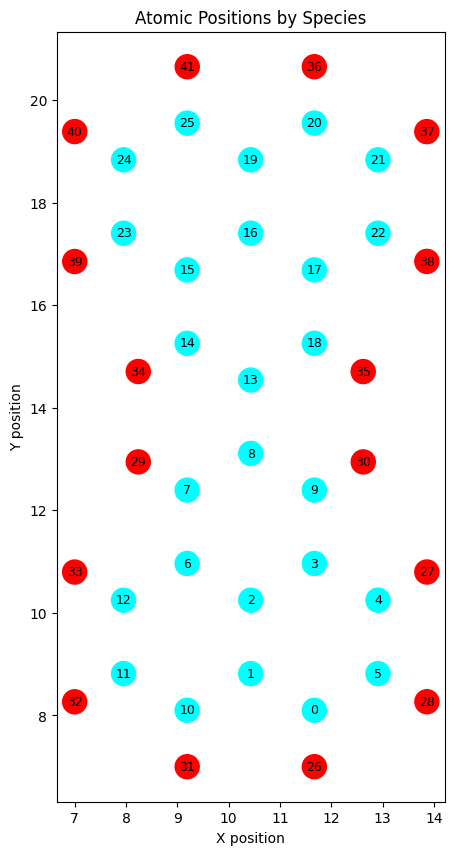

In [50]:
atoms = read('./struct.xyz')
element_colors = {'C':'cyan','H':'red'}

plot_atomic_positions_by_species(atoms, element_colors)

### Check DFT calculations

In [2]:
gpaw_file = './struct.gpw'
calc = GPAW(gpaw_file, txt=None)
dos = RestartLCAODOS(calc)
pdos = LCAODOS(calc)


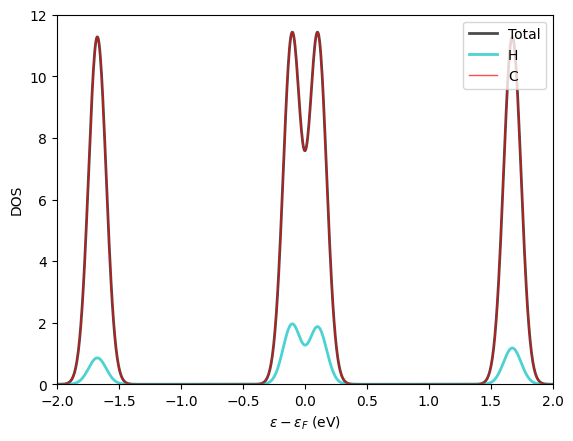

In [3]:
atoms_C_index = np.where(atoms.symbols == 'C')[0]
atoms_H_index = np.where(atoms.symbols == 'H')[0]
num_C_atoms = len(atoms_C_index)
num_H_atoms = len(atoms_H_index)

E_fermi = calc.get_fermi_level()
C_orbitals = pdos.get_atom_indices(atoms_C_index)
H_orbitals = pdos.get_atom_indices(atoms_H_index)

num_spherical_harmonics_C = 13
num_spherical_harmonics_H = 5

tot_basis_func = num_spherical_harmonics_C * num_C_atoms + num_spherical_harmonics_H * num_H_atoms

energies, weights = dos.get_subspace_pdos(range(tot_basis_func))
e, w = fold(energies * Hartree, weights, 5000, 0.1)
w_max = []
for i in range(len(e)):
    if (-4.5 <= e[i] - E_fermi <= 4.5):
        w_max.append(w[i])

w_max = np.asarray(w_max)

e, C_pdos = dos.get_subspace_pdos(C_orbitals)
e, C_pdos = fold(e * Hartree, C_pdos, 5000, 0.1)
e, H_pdos = dos.get_subspace_pdos(H_orbitals)
e, H_pdos = fold(e * Hartree, H_pdos, 5000, 0.1)

plt.plot(e - E_fermi, w, label='Total', c='k', lw=2, alpha=0.7)
plt.plot(e - E_fermi, H_pdos, label='H', c='c', lw=2, alpha=0.7)
plt.plot(e - E_fermi, C_pdos, label='C', c='r', lw=1, alpha=0.7)

plt.axis(
    ymin=0.,
    ymax=12.0,
    xmin=-2,
    xmax=2,
)
plt.xlabel(r'$\epsilon - \epsilon_F \ \rm{(eV)}$')
plt.ylabel('DOS')
plt.legend(loc=1)

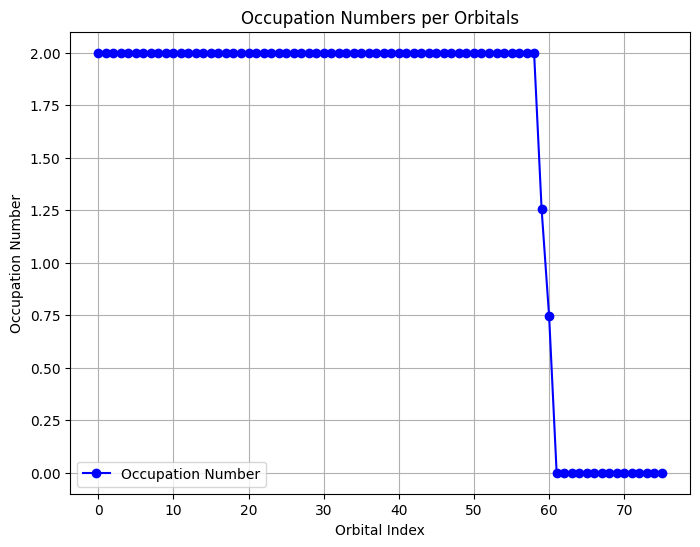

In [4]:
occ = calc.get_occupation_numbers()
# Plot the occupation numbers
plt.figure(figsize=(8, 6))
plt.plot(range(len(occ)), occ, 'bo-', label='Occupation Number')

# Label the plot
plt.title('Occupation Numbers per Orbitals')
plt.xlabel('Orbital Index')
plt.ylabel('Occupation Number')
plt.ylim([-0.1, 2.1])  # Occupation numbers typically range between 0 and 2
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

### Get Hamiltonian and Overlap matrices in the LCAO basis

In [23]:
# Since this is a molecule, I've performed a Gamma point calculation and the assumption is the H_gamma is equivalent to a real space Hamiltonian H_R. 

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= E_fermi * S_lcao

Condition number: 5.4e+04


### Get Hamiltonian and Overlap matrices in the LO basis

In [24]:
# Perform subdiagonalization

nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

SUBDIAG_SPECIES = ("C", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_subdiagonal = rotate_matrix(H_lcao, Usub)
S_subdiagonal = rotate_matrix(S_lcao, Usub)

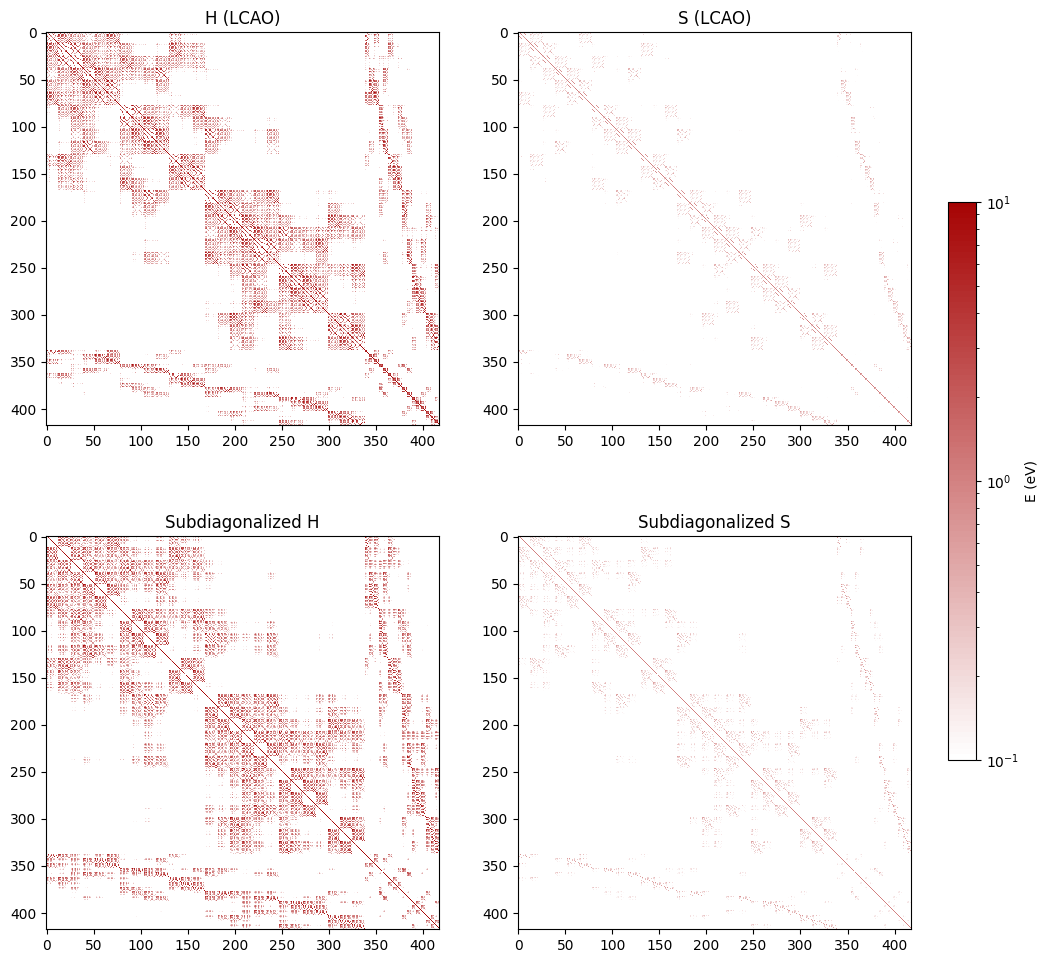

In [27]:
# Note that I'm plotting the absolute values in H and S for ease of visualization.

cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot H_lcao in the first row, first column
cax1 = axs[0, 0].imshow(np.abs(H_lcao), interpolation='nearest', cmap=cm, norm=norm)
axs[0, 0].set_title("H (LCAO)")

# Plot S_lcao in the first row, second column
cax2 = axs[0, 1].imshow(np.abs(S_lcao), interpolation='nearest', cmap=cm, norm=norm)
axs[0, 1].set_title("S (LCAO)")

# Plot H_subdiagonal in the second row, first column
cax3 = axs[1, 0].imshow(np.abs(H_subdiagonal), interpolation='nearest', cmap=cm, norm=norm)
axs[1, 0].set_title("Subdiagonalized H")

# Plot S_subdiagonal in the second row, second column
cax4 = axs[1, 1].imshow(np.abs(S_subdiagonal), interpolation='nearest', cmap=cm, norm=norm)
axs[1, 1].set_title("Subdiagonalized S")

# Add a shared colorbar for all subplots
cbar = fig.colorbar(cax4, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('E (eV)')

plt.show()

### Pick out only C 2pz orbitals 

I know a priori that of the 13 orbitals of C, index '3' corresponds to C 2pz. This is based on visualizing the LOs cube files. If you are interested in, for example, the 1s orbitals, visualize the cube files for the orbitals and find which index produced a cube file that shows 1s behavior. The following calculation shows how to extract only the C 2pz contributions to the Hamiltonian

In [36]:
# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species
active = {'C': [3]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

In [37]:
H_active.shape

(26, 26)

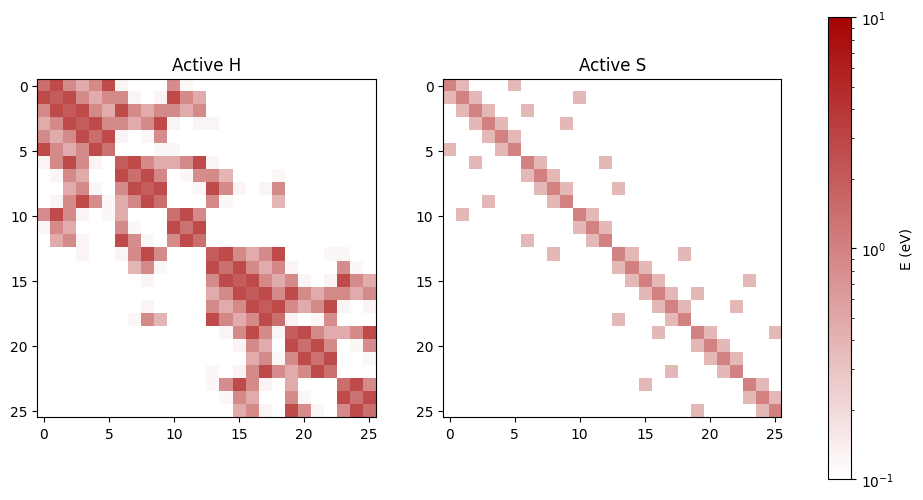

In [38]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized H matrix for the bridge region
cax1 = ax1.imshow(np.abs(H_active), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Active H")

# Plot the subdiagonalized S matrix for the bridge region
cax2 = ax2.imshow(np.abs(S_active), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Active S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()


Based on the ordering of the indices in the visualization of the structure (top of the notebook), and the naming convention in the figure below,

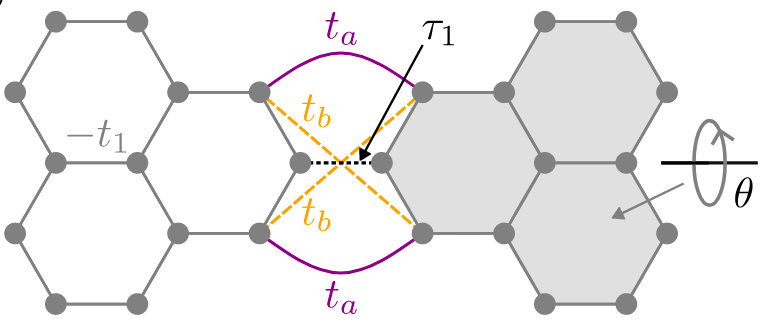

1. t_1 = hopping between atom #1 and #2
2. tau_1 = hopping between atom #8 and #13
3. t_a = hopping between atom #7 and #14
4. t_b = hopping between atom #7 and #18

In [57]:
print("t1 = ",H_active[1,2])
print("tau_1 = ",H_active[8,13])
print("t_a = ",H_active[7,14])
print("t_b = ",H_active[7,18])

# Onsite C pz-pz terms
print("onsite = ",np.diag(H_active))

t1 =  -2.744523604847138
tau_1 =  2.7356465031767185
t_a =  -0.38829595019256424
t_b =  -0.12014393185987088
onsite =  [-1.38166849 -1.93317465 -1.99671338 -1.93732401 -1.38541776 -1.33903335
 -1.93531224 -1.43062076 -1.93023228 -1.43020613 -1.38345327 -1.34026709
 -1.38378126 -1.92981326 -1.43008224 -1.93738229 -1.9966803  -1.93506526
 -1.42818206 -1.93758832 -1.38378934 -1.34044702 -1.38598738 -1.38617879
 -1.33927343 -1.3861508 ]
